In [1]:
import numpy as np 
import pandas as pd
import cv2 
from PIL import Image
import os
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from seaborn import countplot

data_dir = 'data'
annon_dir = data_dir + '/annotations'
imgs_dir = data_dir + '/images'
SPLIT_RATIO = 0.8 # train and validation split ratio
snapshot_Folder = 'keras-retinanet/snapshots'
batch_size = 32

ModuleNotFoundError: No module named 'PIL'

#### Reading data

In [2]:
def read_data():
    class_names = {}
    k = 0
    output = []
    xml_files = glob.glob("{}/*xml".format(annon_dir))
    for i, xml_file in enumerate(xml_files):
        tree = ET.parse(xml_file)

        path = os.path.join(imgs_dir, tree.findtext("./filename"))

        height = int(tree.findtext("./size/height"))
        width = int(tree.findtext("./size/width"))
        xmin = int(tree.findtext("./object/bndbox/xmin"))
        ymin = int(tree.findtext("./object/bndbox/ymin"))
        xmax = int(tree.findtext("./object/bndbox/xmax"))
        ymax = int(tree.findtext("./object/bndbox/ymax"))

        basename = os.path.basename(path)
        basename = os.path.splitext(basename)[0]
        class_name = basename[:basename.rfind("_")].lower()
        if class_name not in class_names:
            class_names[class_name] = k
            k += 1
        
        # making sure bounding boxes are correct
        if xmin >= xmax or ymin >= ymax or xmax > width or ymax > height or xmin < 0 or ymin < 0:
            print("Warning: {} contains invalid box. Skipped...".format(path))
            continue
            
        output.append([path, xmin, ymin, xmax, ymax, class_name])

    # preserve percentage of samples for each class ("stratified")
    output.sort(key=lambda tup : tup[-1])
    return output

In [3]:
data = read_data()
data[1]

NameError: name 'glob' is not defined

2857
saint_bernard


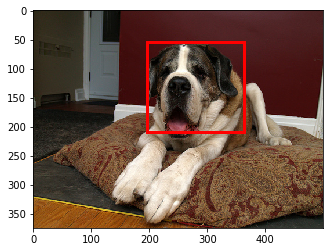

In [27]:
# taking a look at data

i = np.random.randint(len(data))
print(i)
# A rectangle with uper left at xy = (x, y) with specified width, height and rotation angle.
im = np.array(Image.open(data[i][0]), dtype=np.uint8)
# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(im)

xleft,yright = data[i][1], data[i][2]
height = data[i][3]-data[i][1]
width = data[i][4]-data[i][2]
print(data[i][-1])
# print(xleft,yright)
# print(height,width)

# Create a Rectangle patch
rect = patches.Rectangle((xleft,yright),
                         width,
                         height, linewidth=3, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

In [28]:
data_df = pd.DataFrame(data,columns=['path','x1','y1','x2','y2','class'])
data_df.head(3)

,path,x1,y1,x2,y2,class
0,data/images\Abyssinian_1.jpg,333,72,425,158,abyssinian
1,data/images\Abyssinian_10.jpg,72,105,288,291,abyssinian
2,data/images\Abyssinian_100.jpg,151,71,335,267,abyssinian


In [38]:
classes = ['abyssinian', 'american_bulldog', 'american_pit_bull_terrier',
       'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer',
       'british_shorthair', 'chihuahua', 'egyptian_mau',
       'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
       'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond',
       'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland',
       'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue',
       'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu',
       'siamese', 'sphynx', 'staffordshire_bull_terrier',
       'wheaten_terrier', 'yorkshire_terrier']

#### Splitting data

In [31]:
train_df, val_df = train_test_split(data_df, test_size = 0.2, stratify=data_df['class'])
train_df.head()

,path,x1,y1,x2,y2,class
1606,data/images\havanese_115.jpg,103,26,392,236,havanese
2429,data/images\pomeranian_136.jpg,8,6,173,176,pomeranian
1698,data/images\japanese_chin_108.jpg,185,105,328,201,japanese_chin
3286,data/images\Sphynx_1.jpg,63,33,167,142,sphynx
1553,data/images\great_pyrenees_158.jpg,230,134,317,223,great_pyrenees


In [32]:
train_df.to_csv('annotations_train.csv',index=False,header=False)
val_df.to_csv('annots_valid.csv',index=False,header=False)

**making sure the data is balanced**

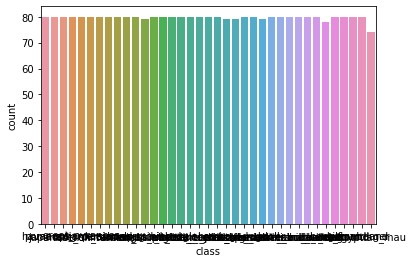

In [33]:
countplot(train_df['class'])

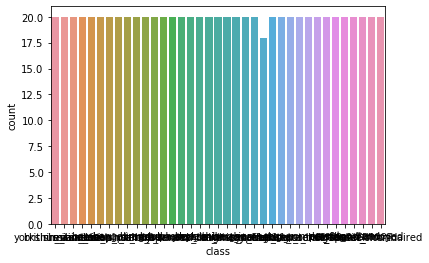

In [34]:
countplot(val_df['class'])

#### Saving the required csv files for the library to work

In [39]:
classes_df=pd.DataFrame()
classes_df['class_name']=classes
classes_df['id']=list(range(0,len(list(classes))))
classes_df.head()

,class_name,id
0,abyssinian,0
1,american_bulldog,1
2,american_pit_bull_terrier,2
3,basset_hound,3
4,beagle,4


In [40]:
classes_df.to_csv('classes.csv',index=False,header=False)

#### Installing the keras-retinanet library

https://github.com/fizyr/keras-retinanet#installation

#### Making the model

In [1]:
classes = ['abyssinian', 'american_bulldog', 'american_pit_bull_terrier',
       'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer',
       'british_shorthair', 'chihuahua', 'egyptian_mau',
       'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
       'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond',
       'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland',
       'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue',
       'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu',
       'siamese', 'sphynx', 'staffordshire_bull_terrier',
       'wheaten_terrier', 'yorkshire_terrier']

In [2]:
import matplotlib.pyplot as plt
from keras_retinanet import keras_retinanet
from keras_retinanet.keras_retinanet import models
from keras import optimizers
from keras_retinanet.keras_retinanet.models import load_model
from keras_retinanet.keras_retinanet.utils.model import freeze as freeze_model
from keras_retinanet.keras_retinanet.preprocessing import csv_generator

Using TensorFlow backend.


In [3]:
# making themodel and loading the weights of the model
model = models.backbone('resnet50').retinanet(num_classes=len(classes),modifier=freeze_model)
model.load_weights('keras_retinanet/snapshots/resnet50_coco_best_v2.1.0.h5', by_name=True,skip_mismatch=True)
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=optimizers.adam(lr=1e-5, clipnorm=0.001)
)

C:\Users\BasuUser\Anaconda3\envs\moein\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 333) vs (720, 256, 3, 3)).
  weight_values[i].shape))
C:\Users\BasuUser\Anaconda3\envs\moein\lib\site-packages\keras\engine\saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((333,) vs (720,)).
  weight_values[i].shape))


In [4]:
model.summary()

Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________

In [5]:
batch_size = 4
data_generator = csv_generator.CSVGenerator(csv_data_file='annotations_train.csv',csv_class_file='classes.csv',
                              batch_size=batch_size)
data_generator_val = csv_generator.CSVGenerator(csv_data_file='annots_valid.csv',csv_class_file='classes.csv', 
                              batch_size=batch_size)

snapshot_folder = 'weights'
history={'losses_val':[], 'losses':[]}
ep = 1

In [6]:
# model.evaluate_generator(data_generator_val, workers=8, use_multiprocessing=False, verbose=1)

In [13]:
def evaluate():
    l,r_l,c_l = model.evaluate_generator(data_generator_val, workers=8, use_multiprocessing=False)
#     print('Total loss: ',l,' Regression loss: ', r_l,' classification loss: ',c_l)
    return l,r_l,c_l

* freeze-backbone: freeze the backbone layers, particularly useful when we use a small dataset, to avoid overfitting
* random-transform: randomly transform the dataset to get data augmentation
* weights: initialize the model with a pretrained model (your own model or one released by Fizyr)
* batch-size: training batch size, higher value gives smoother learning curve
* steps: number of steps for epochs
* epochs: number of epochs to train
* csv: annotations files generated by the script above

In [4]:
import pandas as pd
training_samples = len(pd.read_csv('annotations_train.csv'))
training_samples

ModuleNotFoundError: No module named 'pandas'

In [9]:
import numpy as np

Epoch : 80 

Epoch 1/1
736/736 [==============================] - 506s 688ms/step - loss: 0.0161 - regression_loss: 0.0137 - classification_loss: 0.0023

Epoch : 81 

Epoch 1/1
736/736 [==============================] - 507s 689ms/step - loss: 0.0158 - regression_loss: 0.0135 - classification_loss: 0.0023


ValueError: setting an array element with a sequence.

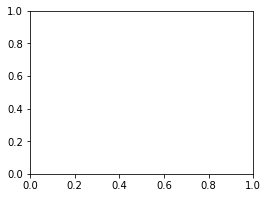

In [38]:
epochs = 200
steps = training_samples//batch_size

for i in range(ep,epochs):
    
    print('Epoch :',i,'\n')
    # fit for one epoch
    h = model.fit_generator(data_generator, epochs=1, steps_per_epoch=steps, verbose=1)
    ep = i + 1
    history['losses'].append(h.history)
    model.save(snapshot_folder+'/model_' + str(i) + '.h5')
    # save model every 10 epochs
    if i % 3 == 0:
        evaluate()
        history['losses_val'].append((evaluate(),i))
        plot_history()
        
    print('\n','='*80)

In [37]:
model.optimizer.learning_rate = model.optimizer.learning_rate/10 

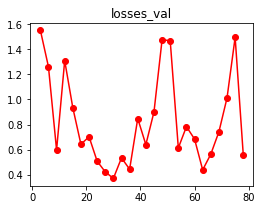

In [33]:
def plot_history(loss='losses_val'):
    total_val_loss = [i[0] for i in history[loss]]
    plt.figure(figsize=(4,3))
    plt.plot([i*3 for i in range(1,1+len(total_val_loss))],total_val_loss,'ro-')
    plt.title(loss)
    plt.show()
    
plot_history()

In [108]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras_retinanet
from keras_retinanet.keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.keras_retinanet.utils.colors import label_color

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
model_inf = models.load_model(snapshot_folder+'/model_' + str(9) + '.h5', backbone_name='resnet50')
model_inf = models.convert_model(model) # converting to inference mode

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [111]:
classes_dic={}
i=0
for c in classes:
    classes_dic[i]=c
    i+=1


In [112]:
def test(loc,thresh=0.5):
    # load image
    image = read_image_bgr(loc)
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    # process image
    start = time.time()
    boxes, scores, labels = model_inf.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < thresh:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(classes_dic[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

683
processing time:  0.10771036148071289


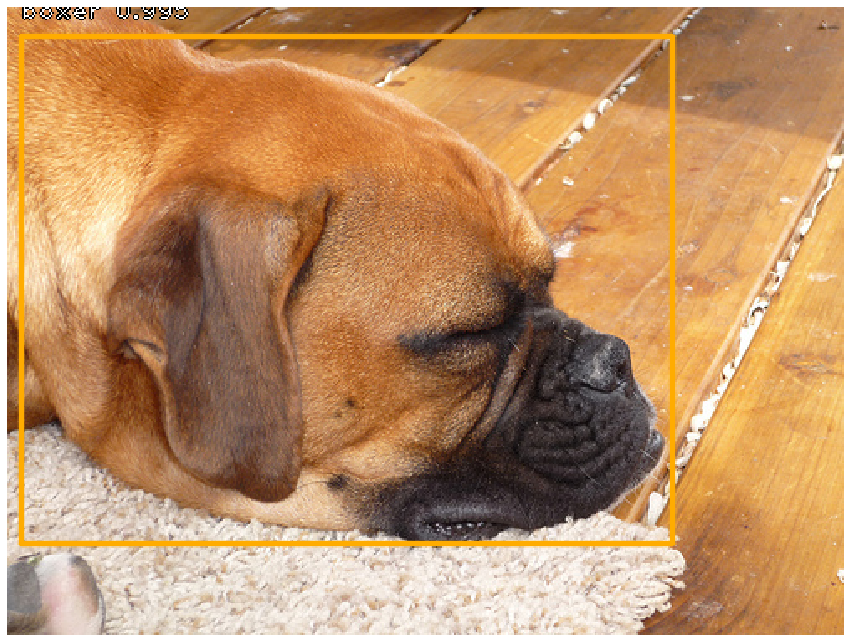

In [117]:
# load image
index = np.random.randint(1,len(val_data))
print(index)
test(val_data.loc[index][0],0.7)

processing time:  0.1186823844909668


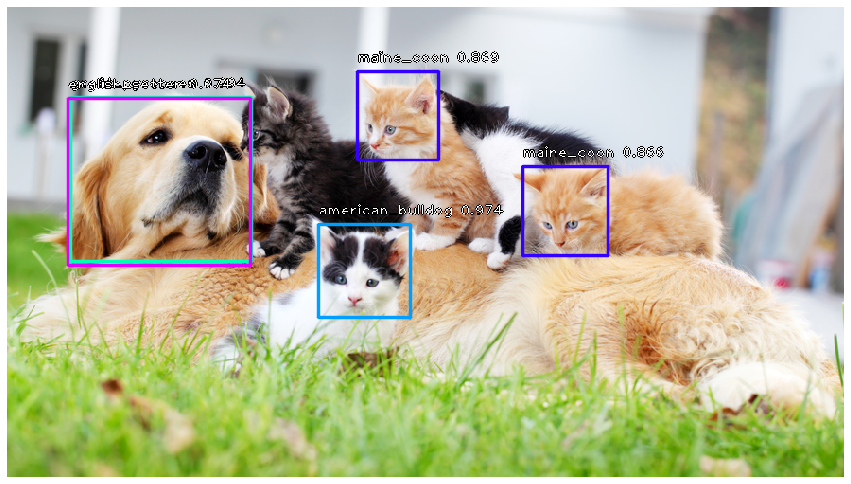

processing time:  0.11765694618225098


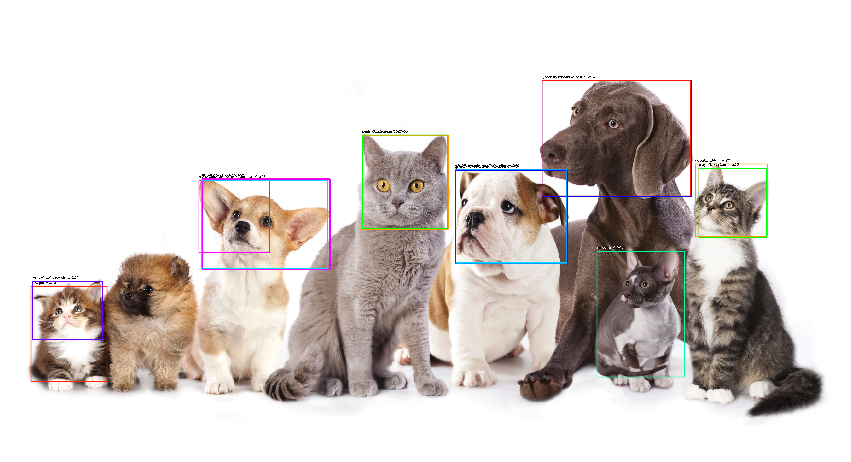

In [115]:
test('sample/img1.jpg')
test('sample/img2.jpg',0.2)